In [29]:
from prometheus_client import CollectorRegistry, Gauge, pushadd_to_gateway

# Создание метрики
registry = CollectorRegistry()
g = Gauge('test_metric', 'Test upload', registry=registry)

# Увеличение значения метрики
g.set(7.1)  # Устанавливаем значение метрики

# Отправка метрики в Prometheus
pushadd_to_gateway('127.0.0.1:9091', job='test_job', registry=registry)

In [30]:
g.set(100)
pushadd_to_gateway('127.0.0.1:9091', job='test_job', registry=registry)

---

In [31]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from prometheus_client import CollectorRegistry, Gauge, pushadd_to_gateway

In [32]:
data = pd.read_csv("./data/winequality-red.csv", sep=";")

In [33]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [34]:
# Посмотрим на распределение статистик
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [35]:
# Все фичи числовые пропусков нет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


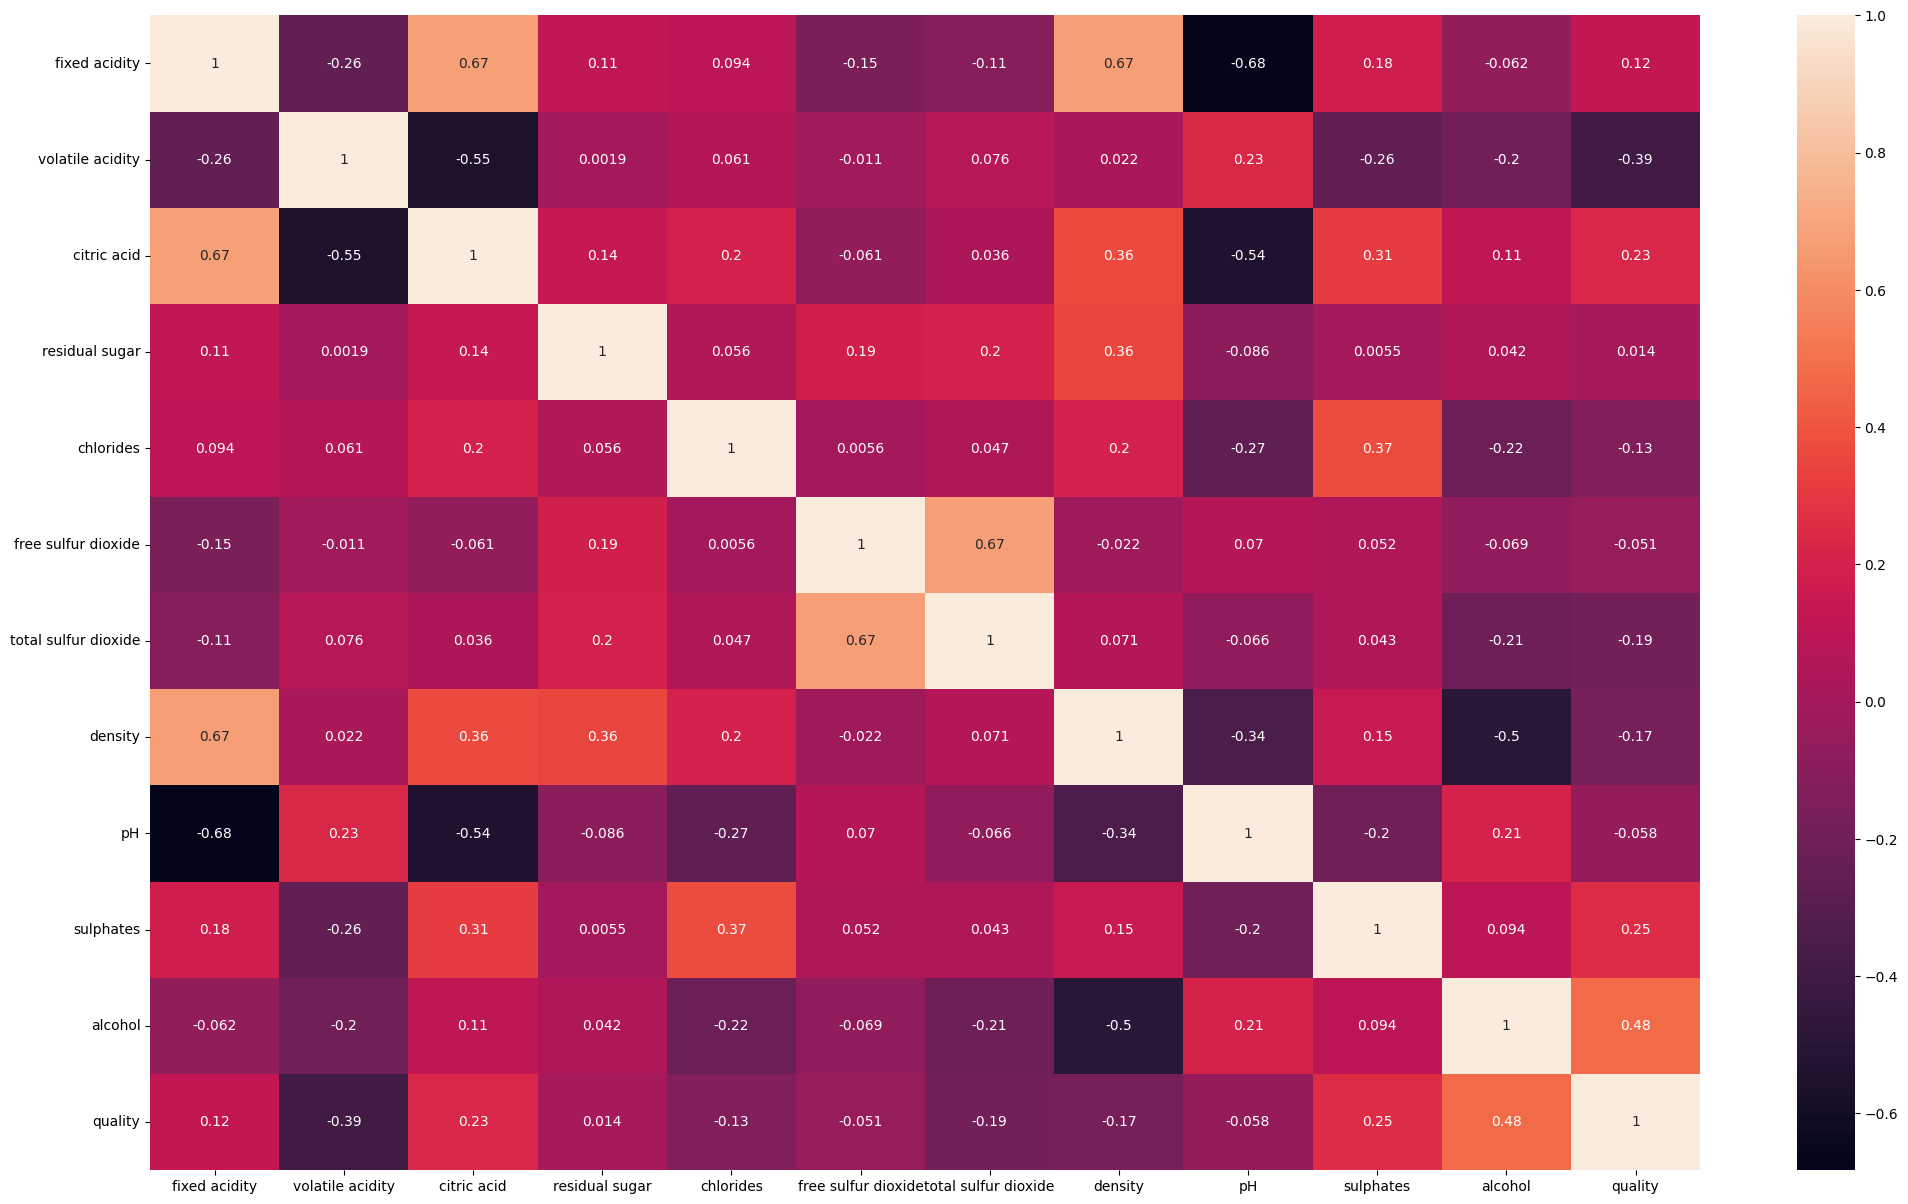

In [36]:
# Почистим мультиколлинеарность
fig, axes = plt.subplots(1, 1, figsize=(25, 15))
sns.heatmap(data.corr(), annot=True, ax=axes)
plt.show()

In [37]:
data.drop(["density", "pH", "citric acid"], axis=1, inplace=True)

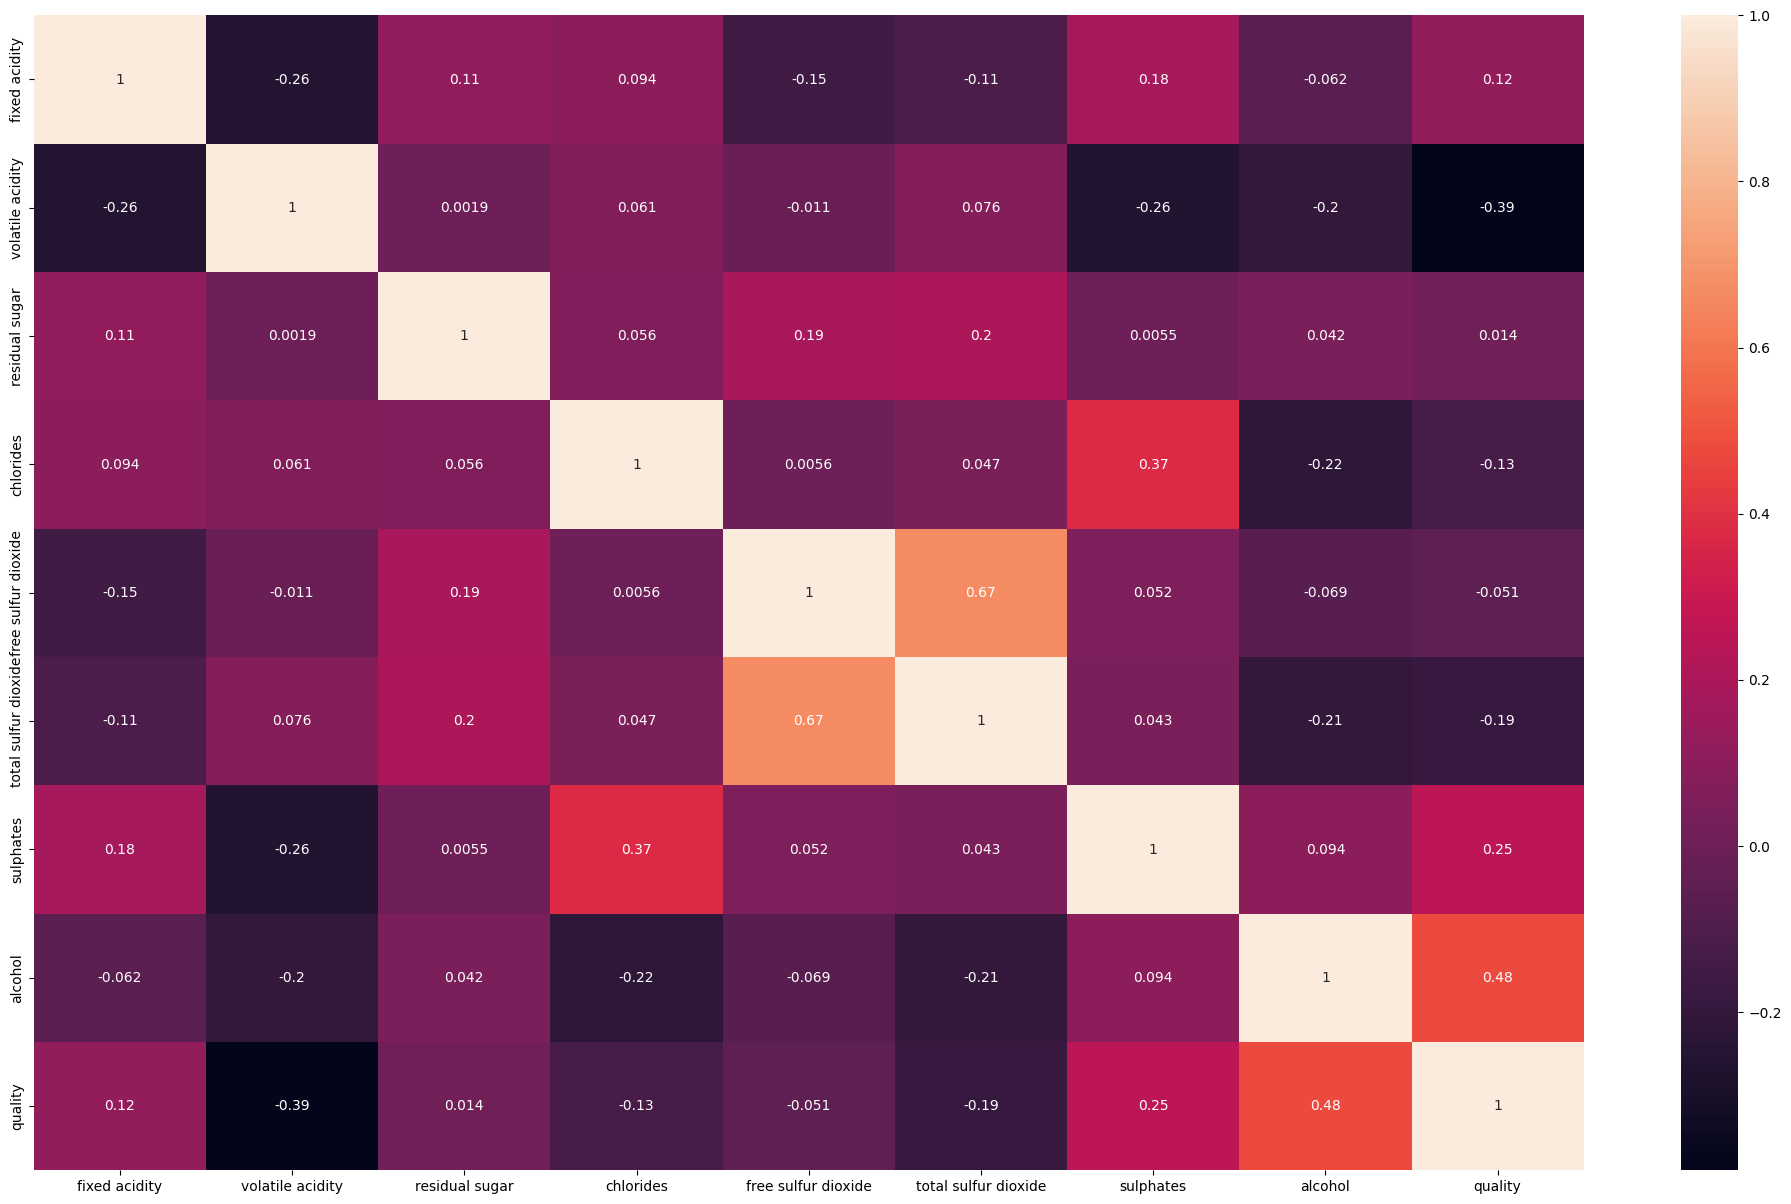

In [38]:
# Глянем
fig, axes = plt.subplots(1, 1, figsize=(25, 15))
sns.heatmap(data.corr(), annot=True, ax=axes)
plt.show()

In [39]:
# Перекодируем целевую на бинарную по разбиению на границе < 5
data["quality"] = data["quality"].apply(lambda x: 0 if x<5 else 1)
data["quality"].describe()

count    1599.000000
mean        0.960600
std         0.194605
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: quality, dtype: float64

In [40]:
# Получим таргет и фичи
X = data.drop(["quality"], axis=1)
y = data["quality"]

In [44]:
# Создаем Pipeline для использовании в будующем дообучении
pipeline = Pipeline(
    [("scaler", StandardScaler()), ("logistic_regression", LogisticRegression(solver="saga"))]
)

# Определяем параметры для GridSearchCV
param_grid = {
    "logistic_regression__C": [0.1, 0.5, 1, 1.5, 2],
    "logistic_regression__penalty": ["l1", "l2"],
}

# GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring="accuracy", cv=10)
grid_search.fit(X, y)

# Соберем метрики со всех итераций gridsearch
metrics = grid_search.cv_results_["mean_test_score"]

# Сохранение обученной модели
joblib.dump(grid_search, "./data/wine_classif.pkl")

['./data/wine_classif.pkl']